In [363]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import time
%matplotlib inline

In [214]:
powerplants = pd.read_csv('powerplants.csv')
powerplants.dtypes

Plant_Code      int64
Plant_Name     object
Utility_Na     object
Utility_ID      int64
sector_nam     object
City           object
County         object
Zip             int64
Street_Add     object
PrimSource     object
Total_MW      float64
Coal_MW       float64
NG_MW         float64
Crude_MW      float64
Bio_MW        float64
Hydro_MW      float64
HydroPS_MW    float64
Nuclear_MW    float64
Solar_MW      float64
Wind_MW       float64
Geo_MW        float64
Other_MW      float64
source_des     object
tech_desc      object
Source         object
Period          int64
Latitude      float64
Longitude     float64
dtype: object

In [215]:
continental_us_bounds = Polygon([
    [
      -126.474609375,
      24.046463999666567
    ],
    [
      -64.775390625,
      24.046463999666567
    ],
    [
      -64.775390625,
      50.45750402042058
    ],
    [
      -126.474609375,
      50.45750402042058
    ],
    [
      -126.474609375,
      24.046463999666567
    ]
])

In [441]:
points = powerplants.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
powerplants = gpd.GeoDataFrame(powerplants, geometry=points)
powerplants.crs = {'init': 'epsg:4326'}
powerplants = powerplants[powerplants.within(continental_us_bounds)].to_crs(epsg=5070)

In [480]:
states = gpd.read_file('cb_2016_us_state_500k/cb_2016_us_state_500k.shp')
states = states[states.within(continental_us_bounds)].to_crs(epsg=5070)

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

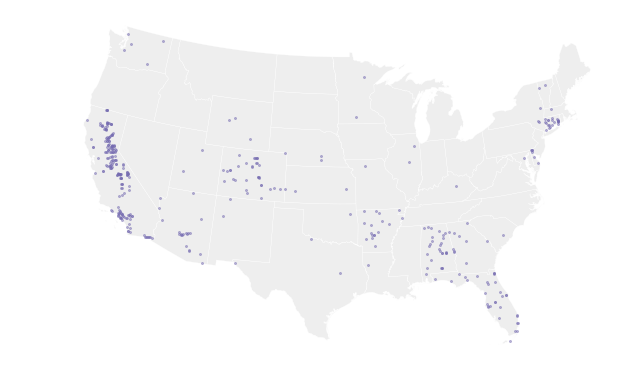

In [443]:
ax = states.plot(
    color='#dedede',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10)
)
powerplants[:400].plot(color='#756bb1', alpha=0.45, ax=ax)
ax.axis('off')

## 1. How many power plants are in each state?

---> I'm taking only the 500 first power plants otherwise it's too slow...

In [491]:
%%time

# With intersects
def does_intersect(row):
    return pd.Series({
        'state': row['NAME'], 
        'powerplants': powerplants.intersects(row.geometry).sum()})

result = states.apply(does_intersect, axis=1).sort_values(by='powerplants', ascending=False)

CPU times: user 1min 6s, sys: 309 ms, total: 1min 7s
Wall time: 1min 7s


In [492]:
result.head()

,powerplants,state
4,1222,California
44,461,North Carolina
49,396,Texas
43,372,New York
17,274,Minnesota


In [489]:
%%time 

# Or with spatial join
states_with_powerplants = gpd.sjoin(states.reset_index(), powerplants, how='inner', op='intersects')
states['powerplants'] = states_with_powerplants.groupby('index').size()
states['powerplants'] = states['powerplants'].fillna(0)

CPU times: user 1.3 s, sys: 20.7 ms, total: 1.32 s
Wall time: 1.37 s


In [490]:
states[['NAME', 'powerplants']].sort_values(by='powerplants', ascending=False).head()

,NAME,powerplants
4,California,1222
44,North Carolina,461
49,Texas,396
43,New York,372
17,Minnesota,274


## 2. Which power plants are in New York?

In [493]:
%%time
ny_powerplants = (powerplants[
    powerplants.intersects(
        states.loc[states[states['NAME'] == 'New York'].index[0]].geometry)])

CPU times: user 3.52 s, sys: 18.9 ms, total: 3.54 s
Wall time: 3.57 s


In [494]:
ny_powerplants.head()

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,Zip,Street_Add,PrimSource,...,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
49,88,Ashokan,New York Power Authority,15296,Electric Utility,Kingston,Ulster,12401,Route 28A,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 4.6 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,41.949000,-74.206300,POINT (1778509.130207101 2310035.976360777)
363,579,Central Hudson High Falls,Central Hudson Gas & Elec Corp,3249,Electric Utility,High Falls,ULSTER,12440,Route 213,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 3.2 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,41.828814,-74.131877,POINT (1787541.982035094 2298339.506578956)
387,625,Upper Mechanicville,New York State Elec & Gas Corp,13511,Electric Utility,Town of Stillwater,Saratoga,12170,40 Hudson Avenue,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 18.4 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,42.912600,-73.680500,POINT (1795565.8292625 2424766.143047533)
469,808,Jarvis (Hinckley),New York Power Authority,15296,Electric Utility,Hinckley,Oneida,13352,None,hydroelectric,...,0.0,NaN,NaN,Hydroelectric = 9 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.312100,-75.109000,POINT (1672837.584526353 2442171.36152681)
1169,2480,Danskammer Generating Station,Danskammer Energy,58971,IPP Non-CHP,Newsburgh,Orange,12550,994 River Road,natural gas,...,0.0,NaN,NaN,"Natural Gas = 478.7 MW, Petroleum = 5 MW",Natural Gas Steam Turbine; Petroleum Liquids;,"EIA-860, EIA-860M and EIA-923",201607,41.571247,-73.974981,POINT (1806757.474462068 2273249.929613073)


In [452]:
%%time
# Or with spatial join
ny_powerplants = gpd.sjoin(
    states[states['NAME'] == 'New York'].reset_index(), 
    powerplants, 
    how='inner', 
    op='intersects')

CPU times: user 952 ms, sys: 9 ms, total: 961 ms
Wall time: 984 ms


In [453]:
ny_powerplants.head()

,index,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,...,Solar_MW,Wind_MW,Geo_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude
0,43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,...,0.0,0.0,NaN,NaN,Hydroelectric = 25.9 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.275800,-75.156700
0,43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,...,0.0,0.0,NaN,NaN,Hydroelectric = 18.3 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.291861,-75.147734
0,43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,...,0.0,0.0,NaN,NaN,Hydroelectric = 9 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.312100,-75.109000
0,43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,...,0.0,0.0,NaN,NaN,Hydroelectric = 1.5 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.096823,-73.582107
0,43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,...,0.0,0.0,NaN,NaN,Hydroelectric = 2.2 MW,Conventional Hydroelectric,"EIA-860, EIA-860M and EIA-923",201607,43.098711,-73.525271


## 3. Which state has the most hydroelectric power plants?

In [495]:
states_with_hydro = gpd.sjoin(states.reset_index(), powerplants[powerplants['PrimSource'] == 'hydroelectric'], how='inner', op='intersects')
states['hydro_powerplants'] = states_with_hydro.groupby('index').size()
states['hydro_powerplants'] = states['hydro_powerplants'].fillna(0)
states.sort_values(by='hydro_powerplants', ascending=False).head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,Total_energy,Total_Solar_MW,powerplants,hydro_powerplants
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,(POLYGON ((-2066923.366569909 1403703.12227994...,76586.9,8140.7,1222,245.0
43,0400000US36,122053048985,19243095591,36,00,New York,36,01779796,NY,(POLYGON ((1971480.202032173 2276849.286283191...,39908.5,94.3,372,159.0
51,0400000US53,172113416541,12558451099,53,00,Washington,53,01779804,WA,(POLYGON ((-1955449.971638548 3053081.84922863...,36222.4,0.0,138,77.0
11,0400000US16,214042908012,2398669593,16,00,Idaho,16,01779783,ID,"POLYGON ((-1673716.59961153 2566368.716114565,...",5393.4,0.0,136,75.0
46,0400000US41,248604268242,6195105690,41,00,Oregon,41,01155107,OR,(POLYGON ((-2102992.964713396 2892293.20926895...,10878.7,27.0,145,60.0


In [464]:
# Or
def does_intersect(row):
    return pd.Series({
        'stats': row['NAME'], 
        'powerplants': powerplants[powerplants['PrimSource'] == 'hydroelectric'].intersects(row.geometry).sum()})

states.apply(does_intersect, axis=1).sort_values(by='powerplants', ascending=False).head()

,powerplants,stats
4,245,California
43,159,New York
51,77,Washington
11,75,Idaho
46,60,Oregon


## 4. Which state produces the most energy from coal?

In [470]:
def does_intersect(row):
    return pd.Series({
        'stats': row['NAME'], 
        'powerplants': powerplants[(powerplants.intersects(row.geometry))&(powerplants['PrimSource'] == 'coal')]['Total_MW'].sum()})

states.apply(does_intersect, axis=1).sort_values(by='powerplants', ascending=False).head()

,powerplants,stats
49,24764.5,Texas
13,16596.1,Indiana
45,15322.0,Ohio
12,14902.8,Illinois
35,13422.7,Kentucky


In [472]:
#OR
states_with_hydro = gpd.sjoin(states.reset_index(), powerplants[powerplants['PrimSource'] == 'coal'], how='inner', op='intersects')
states['coal_energy'] = states_with_hydro.groupby('index')['Total_MW'].sum()
states['coal_energy'] = states['coal_energy'].fillna(0)
states.sort_values(by='coal_energy', ascending=False).head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,powerplants,hydro_powerplants,coal_energy
49,0400000US48,676633459408,19025991684,48,00,Texas,48,01779801,TX,(POLYGON ((123936.1019064796 740130.3543446567...,396,24764.5,24764.5
13,0400000US18,92790545247,1536767065,18,00,Indiana,18,00448508,IN,"POLYGON ((687448.805641539 1680665.81952055, 6...",133,16596.1,16596.1
45,0400000US39,105833122995,10264595056,39,00,Ohio,39,01085497,OH,(POLYGON ((1093838.145885901 2142994.050332695...,148,15322.0,15322.0
12,0400000US17,143788697679,6206693598,17,00,Illinois,17,01779784,IL,"POLYGON ((378605.4071617679 1916203.674434469,...",200,14902.8,14902.8
35,0400000US21,102266279759,2388770991,21,00,Kentucky,21,01779786,KY,(POLYGON ((584560.0401865917 1518183.088671221...,46,13422.7,13422.7


## 5. Map states with nuclear power plants in red, and states without in grey. Do the same thing for solar.

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

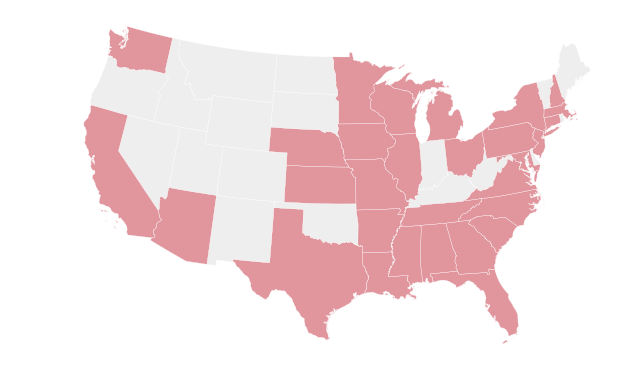

In [287]:
ax = states.plot(
    color='#dedede',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10)
)

states[states.apply(lambda x: powerplants[powerplants['PrimSource'] == 'nuclear'].intersects(x.geometry).any(), axis=1)].plot(
    color='#d53e4f',
    linewidth=0,
    ax=ax
)

ax.axis('off')

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

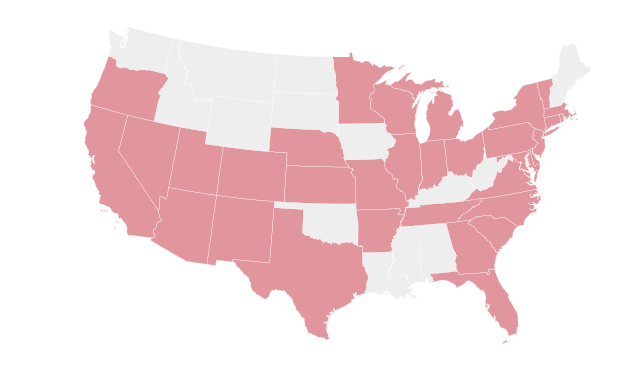

In [288]:
ax = states.plot(
    color='#dedede',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10)
)

states[states.apply(lambda x: powerplants[powerplants['PrimSource'] == 'solar'].intersects(x.geometry).any(), axis=1)].plot(
    color='#d53e4f',
    linewidth=0,
    ax=ax
)

ax.axis('off')

## 7. Make a map of total energy produced by each state, with little being a light color and high emissions being a brighter/darker color.

In [498]:
energy_produced = states

def does_intersect(row):
    return powerplants[powerplants.intersects(row.geometry)]['Total_MW'].sum()

energy_produced['Total_MW'] = states.apply(does_intersect, axis=1)

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

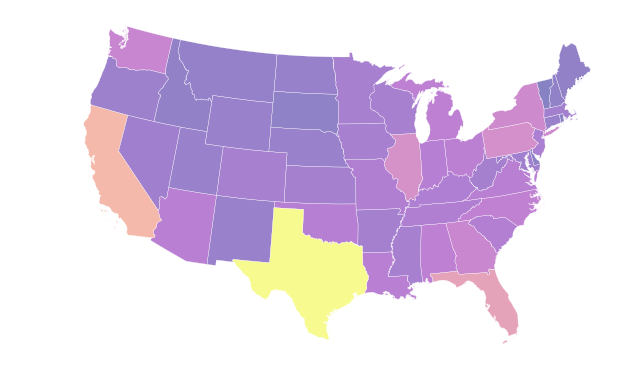

In [501]:
ax = energy_produced.plot(
    cmap='plasma',
    column='Total_MW',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')

In [497]:
# OR
states_with_powerplants = gpd.sjoin(states.reset_index(), powerplants, how='inner', op='intersects')
states['Total_energy'] = states_with_powerplants.groupby('index')['Total_MW'].sum()
states['Total_energy'] = states['Total_energy'].fillna(0)

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

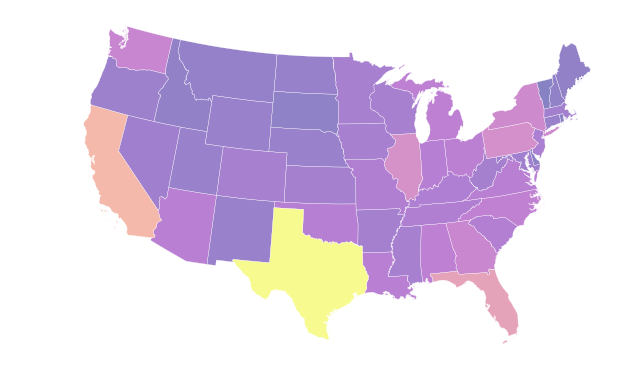

In [500]:
ax = states.plot(
    cmap='plasma',
    column='Total_MW',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')

## 8. Make a map of total wind (or solar or coal) energy produced by each state, with little being a light color and high emissions being a brighter/darker color.

In [496]:
states_with_powerplants = gpd.sjoin(states.reset_index(), powerplants[powerplants['PrimSource'] == 'solar'], how='inner', op='intersects')
states['Total_Solar_MW'] = states_with_powerplants.groupby('index')['Total_MW'].sum()
states['Total_Solar_MW'] = states['Total_Solar_MW'].fillna(0)

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

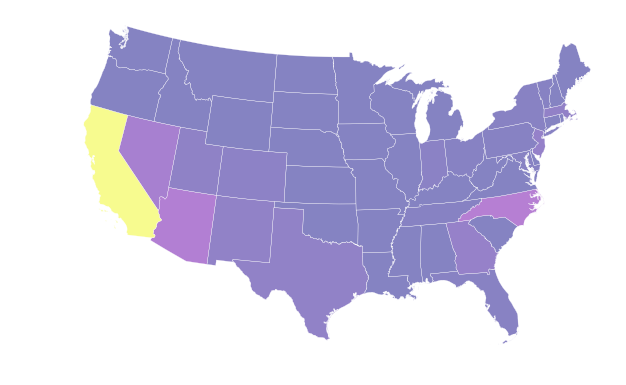

In [499]:
ax = states.plot(
    cmap='plasma',
    column='Total_Solar_MW',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')

## 9. Make a map of average air quality of each states, with high quality being light red and low quality being dark red

In [502]:
stations = pd.read_csv('pm25_annual_fixed.csv')
stations.dtypes

State Code                         int64
County Code                        int64
Site Num                           int64
Parameter Code                     int64
POC                                int64
Latitude                         float64
Longitude                        float64
Datum                             object
Parameter Name                    object
Sample Duration                   object
Pollutant Standard                object
Metric Used                       object
Method Name                       object
Year                               int64
Units of Measure                  object
Event Type                        object
Observation Count                  int64
Observation Percent                int64
Completeness Indicator            object
Valid Day Count                    int64
Required Day Count                 int64
Exceptional Data Count             int64
Null Data Count                    int64
Primary Exceedance Count         float64
Secondary Exceed

In [503]:
stations_points = stations.apply(lambda x: Point(x.Longitude, x.Latitude), axis=1)
stations = gpd.GeoDataFrame(stations, geometry=stations_points)
stations.crs = {'init': 'epsg:4326'}
stations = stations[stations.within(continental_us_bounds)].to_crs(epsg=5070)

In [524]:
states_air_quality = gpd.sjoin(states.reset_index(), stations, how='inner', op='intersects')
states['avg_air_quality'] = states_air_quality.groupby('index')['Arithmetic Mean'].mean()
states['avg_air_quality'] = states['avg_air_quality'].fillna(0)
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,Total_energy,Total_Solar_MW,powerplants,hydro_powerplants,Total_MW,avg_air_quality,worst_air_quality
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,(POLYGON ((760323.7307427037 857474.7284922774...,29654.0,0.0,72,23.0,29654.0,8.600705,47.7
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,POLYGON ((-1746851.979208977 1221914.112159756...,27083.4,1583.8,113,7.0,27083.4,7.126441,21.5
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((122663.9817664425 1495564.993218174,...",14706.7,12.0,55,19.0,14706.7,7.344940,16.6
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,(POLYGON ((-2066923.366569909 1403703.12227994...,76586.9,8140.7,1222,245.0,76586.9,9.353585,46.4
5,0400000US08,268429343790,1175112870,08,00,Colorado,08,01779779,CO,POLYGON ((-1123222.583672025 1807303.824289338...,15807.9,206.2,153,43.0,15807.9,5.868046,26.2


(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

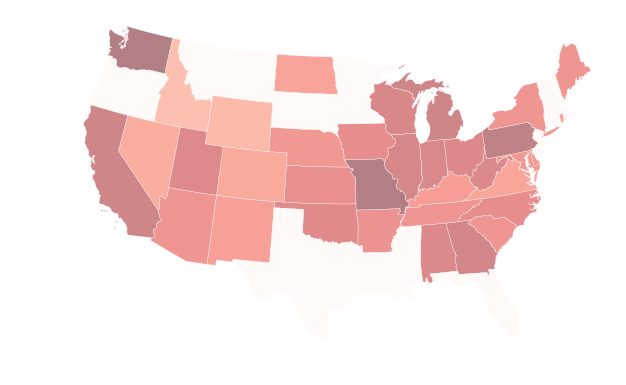

In [525]:
ax = states.plot(
    cmap='Reds',
    column='avg_air_quality',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')

## 10. Make a map of worst air quality measured in each state, with high quality being light red and low quality being dark red

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

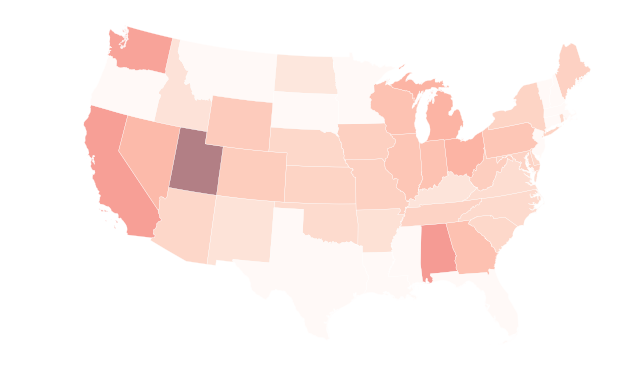

In [527]:
states_air_quality = gpd.sjoin(states.reset_index(), stations, how='inner', op='intersects')
states['worst_air_quality'] = states_air_quality.groupby('index')['1st Max Value'].max()
states['worst_air_quality'] = states['worst_air_quality'].fillna(0)

ax = states.plot(
    cmap='Reds',
    column='worst_air_quality',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')

## 11. Map of average PM2.5 measurement by county

In [644]:
counties = gpd.read_file('cb_2016_us_county_500k/cb_2016_us_county_500k.shp')
counties = counties[counties.within(continental_us_bounds)].to_crs(epsg=5070)

In [645]:
counties_air_quality = gpd.sjoin(counties.reset_index(), stations, how='inner', op='intersects')
counties['avg_air_quality'] = counties_air_quality.groupby('index')['Arithmetic Mean'].mean()
counties['avg_air_quality'] = counties['avg_air_quality'].fillna(0)

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

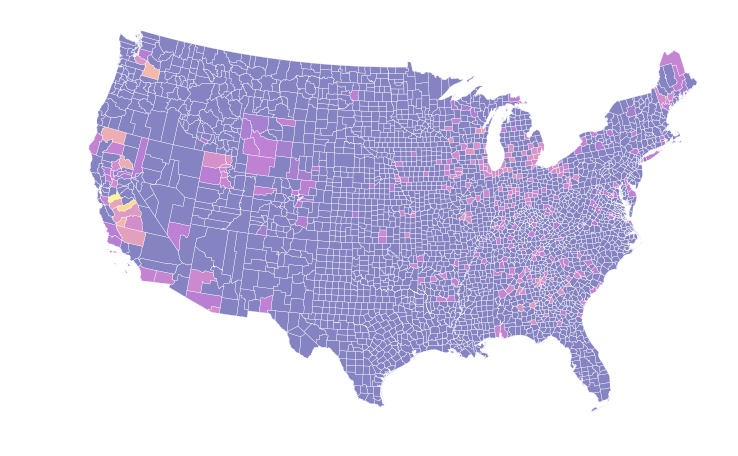

In [677]:
ax = counties.plot(
    cmap='plasma',
    column='avg_air_quality',
    edgecolor='white',
    linewidth=0.25,
    figsize=(12,12)
)
ax.axis('off')

## 12. Make a map with color coded power plants, and a 100 mile circle about major American cities.

In [650]:
cities = gpd.read_file('ne_10m_populated_places/ne_10m_populated_places.shp')
cities = cities[cities.within(continental_us_bounds)].to_crs(epsg=5070)

In [674]:
cities = cities[cities['ADM0_A3'] == 'USA'].to_crs({'proj': 'merc'})
powerplants = powerplants.to_crs(cities.crs)
states = states.to_crs(cities.crs)

(-14210347.848541735,
 -7131041.5710879602,
 2617803.8133198316,
 6483596.9088759366)

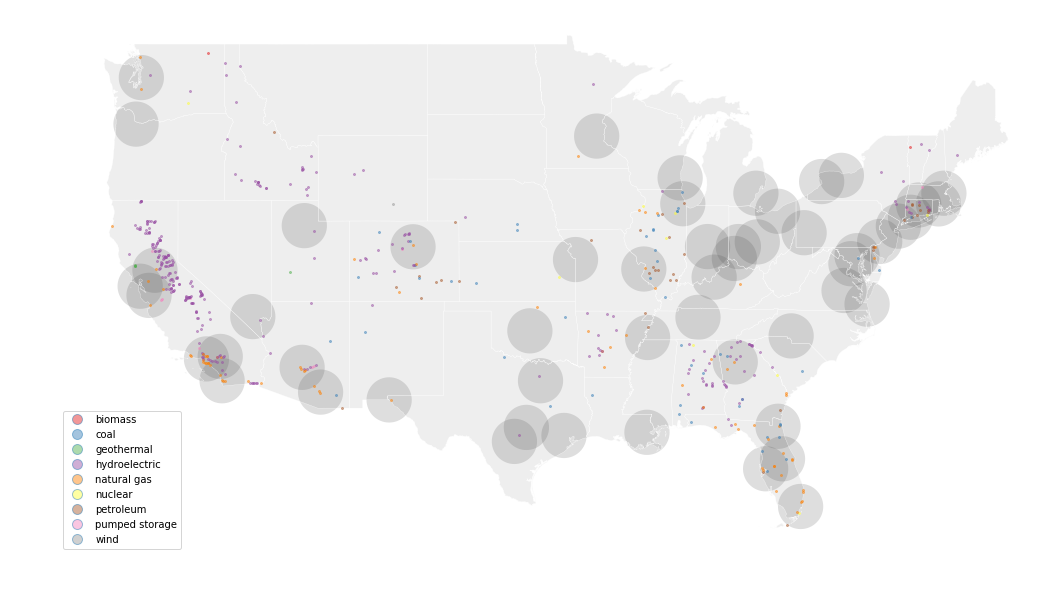

In [678]:
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-populated-places/
# if( a > 10000000 ) then
# x = 14

ax = states.plot(
    color='#dedede',
    edgecolor='white',
    linewidth=0.25,
    figsize=(20,10)
)
# 100 miles = 160934 meters
buffered_cities = cities[cities['POP2015'] > 13].buffer(160934).plot(color='#494949', alpha=0.18, linewidth=0, ax=ax)
powerplants[:500].plot(column='PrimSource', alpha=0.45, ax=ax, legend=True)
ax.axis('off')

## 13. Which states have the most renewable plants, as a % of total plants? (include hydro, wind, solar)

In [561]:
renewable_plants = [
    'hydroelectric',
    'wind',
    'solar',
    'geothermal'
]

states_with_powerplants = gpd.sjoin(
    states.reset_index(), 
    powerplants, 
    how='inner', 
    op='intersects')

states['renewable_pct'] = (states_with_powerplants.groupby('index')
                           .apply(lambda x: 
                                  x[x['PrimSource'].isin(renewable_plants)]
                                  ['PrimSource'].count() / len(x) ))

(-2586829.4388886895,
 2488915.8729062313,
 124423.84046021817,
 3317717.6387093915)

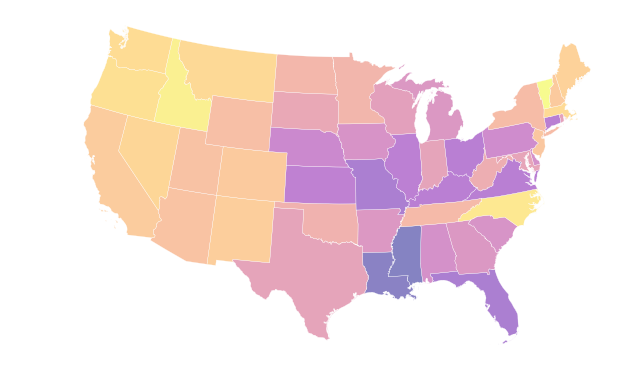

In [562]:
ax = states.plot(
    cmap='plasma',
    column='renewable_pct',
    edgecolor='white',
    linewidth=0.25,
    figsize=(10,10),
)

ax.axis('off')